# Dataset

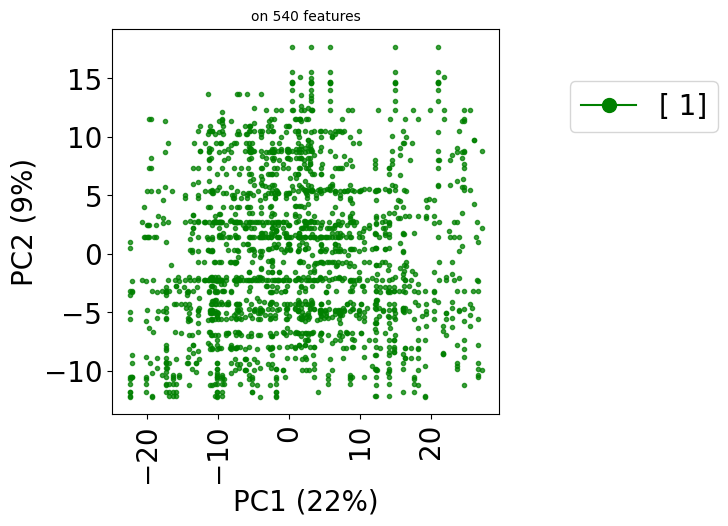

In [2]:
import stanscofi.utils
import stanscofi.datasets

dataset_name="Gottlieb"
dataset_folder="datasets/"

data_args = stanscofi.utils.load_dataset(dataset_name, dataset_folder)
dataset = stanscofi.datasets.Dataset(**data_args)

dataset.visualize(withzeros=False)

# Metrics (full dataset)

In [7]:
## take as input y_true, y_pred
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from scipy.stats import kendalltau, spearmanr

## take as input y_true[np.argsort(-y_pred)]
import subprocess as sb
url_code="https://gist.githubusercontent.com/bwhite/3726239/raw/2c92e90259b01b4a657d20c0ad8390caadd59c8b/rank_metrics.py"
sb.call("wget -qnc %s" % url_code, shell=True)
from rank_metrics import mean_reciprocal_rank, r_precision, precision_at_k, average_precision, dcg_at_k, ndcg_at_k

k=10
MRR = lambda y_true, y_pred : mean_reciprocal_rank(y_true[np.argsort(-y_pred)])
RP = lambda y_true, y_pred : r_precision(y_true[np.argsort(-y_pred)])
Pk = lambda y_true, y_pred : precision_at_k(y_true[np.argsort(-y_pred)], k)
AP = lambda y_true, y_pred : average_precision(y_true[np.argsort(-y_pred)], k)
DCGk = lambda y_true, y_pred : dcg_at_k(y_true[np.argsort(-y_pred)], k)
NDCGk = lambda y_true, y_pred : ndcg_at_k(y_true[np.argsort(-y_pred)], k)

#url_code="https://raw.githubusercontent.com/skondo/evaluation_measures/master/evaluations_measures.py"
def ERR(y_true, y_pred, max=k, max_grade=2):
    ranking = y_true[np.argsort(-y_pred)]
    if max is None:
        max = len(ranking)
    ranking = ranking[:min(len(ranking), max)]
    ranking = map(float, ranking)
    result = 0.0
    prob_step_down = 1.0 
    for rank, rel in enumerate(ranking):
        rank += 1
        utility = (pow(2, rel) - 1) / pow(2, max_grade)
        result += prob_step_down * utility / rank
        prob_step_down *= (1 - utility)  
    return result

# Random splitting of data 

(trying to reproduce paper results even with correlated drugs in the testing and training sets)

In [ ]:
from stanscofi.validation import compute_metrics, plot_metrics
from stanscofi.preprocessing import preprocessing_routine
#from stanscofi.training_testing import traintest_validation_split
from sklearn.model_selection import cross_validate ## works when no PU learning...
from sklearn.model_selection import StratifiedKFold ## otherwise we end up with single-class batches
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from copy import deepcopy

from stanscofi.models import create_scores
from sklearn.svm import SVC ## SVM alone dies on PU learning (as expected)
#from benchscofi.PulearnWrapper import PulearnWrapper
from pulearn import ElkanotoPuClassifier ## let's be conservative and directly use the implementation in pulearn
import random

def train_classifier_RandomSplit(dataset, test_size=0.2, metrics, show_plots=False):
    np.random.seed(rseed)
    random.seed(rseed)
    ## Model parameters: basic SVM
    #model = SVC(C=5., kernel='rbf', gamma=0.5, probability=True, random_state=rseed)
    ## Model parameters: PU learn
    model = ElkanotoPuClassifier(**{
                "estimator": SVC(C=5., kernel='rbf', gamma=0.4, probability=True),
                "hold_out_ratio": 0.2,
            })
    
    ## Random split
    X, y, _,_,_ = preprocessing_routine(dataset, "meanimputation_standardize")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                            random_state=rseed, shuffle=True, stratify=y)
    
    ## Preprocessing and fitting on the training set
    y_train[y_train<1] = -1 ## /!\ unlabeled samples are -1 in pulearn
    y_test[y_test<1] = -1 ## /!\ unlabeled samples are -1 in pulearn
    
    #model.fit(X_train,y_train) ## it overfits (as expected)
    #sc = roc_auc_score(y_train, model.predict_proba(X_train), average="weighted", multi_class="ovr")
    #print("AUC (full test during training): %f" % sc)
    
    ## K-fold Cross-validation (to avoid overfitting)
    ## Write equivalent to cross_validate
    scores = {'test_score': [], 'estimator': []}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rseed) ## to avoid issues with AUC
    for train_index, test_index in skf.split(X_train, y_train):
        scores['estimator'].append(deepcopy(model))
        scores['estimator'][-1].fit(X_train[train_index,:], y_train[train_index])
        scores['test_score'].append(
            roc_auc_score(
                y_train[test_index], 
                scores['estimator'][-1].predict_proba(X_train[test_index,:]).ravel(),
                average="weighted",
                multi_class="ovr"
            )
        )
        print("Fold %d test score = %f" % (len(scores['test_score']), scores['test_score'][-1]))
    model = scores["estimator"][np.argmax(scores['test_score'])]
    print("AUC (full test during training): %f" % np.max(scores['test_score']))
    
    return model, X_train, y_train, X_test, y_test

# Recently reported AUC values in the literature

Algorithm (ref) / Dataset (AUC) | Gottlieb | Cdataset | DNdataset 
------------------------------- | -------- | -------- | ---------- 
HAMN (reported in [1])          | 0.946               | 0.958             | N/A
ANMF (reported in [1])          | 0.938 (from [2])    | 0.952 (from [2])  | N/A
BNNR (reported in [1])          | 0.932               | 0.948             | N/A
DRRS (reported in [1])          | 0.930 (from [2])    | 0.947 (from [2])  | N/A
HGBI (reported in [1])          | 0.829 (from [2])    | 0.858 (from [2])  | N/A
GMF (reported in [2])           | 0.880               | N/A               | N/A
SSLDR (reported in [3])         | 0.982               | 0.987             | 0.978
LRSSL (reported in [4])         |                     |                   |

[1](https://bmcbioinformatics.biomedcentral.com/counter/pdf/10.1186/s12859-020-03898-4.pdf) doi:10.1186/s12859-020-03898-4 (Tables 3 and 4)

[2](https://bmcbioinformatics.biomedcentral.com/counter/pdf/10.1186/s12859-019-2983-2.pdf) doi:10.1186/s12859-019-2983-2 (Tables 3 and 5)

[3](https://arxiv.org/pdf/2206.00262.pdf) arxiv:2206.00262 (Table 2, Table 4 reports comparisons with algorithms not restricted to drug repurposing)
      
Algorithm (ref) / Dataset (AUC) | PREDICT-Gottlieb | LRSSL
------------------------------- | -------- | -------- 
PREDICT (reported in [4])       | 0.902 (from [5])    | N/A            
NTSIM (reported in [4])         | 0.921 (from [5])    | 0.902 (from [5]) 
DDA-SKF (reported in [4])       | 0.929               | 0.931             
LRSSL (reported in [4])         | N/A                 | 0.825 (from [5])   

[4](https://www.frontiersin.org/articles/10.3389/fphar.2021.784171/full) doi:10.3389/fphar.2021.784171 (Table 2)

[5](https://pubmed.ncbi.nlm.nih.gov/29879508/) doi:10.1016/j.ymeth.2018.06.001 (behind a paywall)